# Detect pneuomnia from x-ray images of lungs

This project analyses x-ray images of lungs to identify pneumonia. It takes a hollistic approach and does not segment the image to identify different areas of lunch opacity. Nor does it use any data contained within the DICOM (such as age of patient / sex / scan angle) - the images have been pre-converted to png files using __[mritopng](https://github.com/danishm/mritopng)__ to allow for normal keras preprocessing.

The model applies transfer learning using Resnet50.
 
A number of fine tuning adjustments were made over several iterations which can be observed at the end of this file.

The data used is from the Kaggle dataset found at: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge but note that this notebook does not present a complete solution to this competition. 

In [1]:
# Make sure tensorflow is detecting GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7717833929859468952
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10484137984
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1861805020312231773
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom, numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input, Sequential
from keras.callbacks import ModelCheckpoint  
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from tqdm import tqdm


# Set paths
S1_IMGS = "./img/train_png/"
S1_DICOM = "./img/train/"
S1_LABELS = "./img/labels/stage_1_train_labels.csv"
S1_CLASS_INFO = "./stage_1_detailed_class_info.csv"

# Helper to parse CSV file into dictionary
def parse_csv(df):
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]
    parsed = {}
    
    for n, row in df.iterrows():
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'png': S1_IMGS + '{0}.dcm.png'.format(pid),
                'dicom' : S1_DICOM + '{0}.dcm'.format(pid),
                'label': row['Target'],
                'boxes': []
            }
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))
    
    return parsed            

In [81]:
df = pd.read_csv(S1_LABELS)

patient_class = pd.read_csv(S1_CLASS_INFO, index_col=0)

parsed = parse_csv(df)

In [82]:
# Explore some data using our parser
patient_0 = df['patientId'][0]
print(parsed[patient_0])
print(patient_class.loc[patient_0])

{'png': './img/train_png/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm.png', 'dicom': './img/train/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', 'label': 0, 'boxes': []}
class    No Lung Opacity / Not Normal
Name: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, dtype: object


In [5]:
def draw(data):
    """
    Draw single patient with bounding boxes
    """
    
    di = pydicom.read_file(data['dicom'])
    img = di.pixel_array
    
    img = np.stack([img] * 3, axis = 2)
    
    # add boxes with random colour if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        img = overlay_box(img=img, box=box, rgb=rgb, stroke=6)
        
    plt.imshow(img, cmap=plt.cm.gist_gray)
    plt.axis('off')
    
def overlay_box(img, box, rgb, stroke=1):
    box = [int(b) for b in box]
    
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + widthprint(patient_test)
    
    img[y1:y1 + stroke, x1:x2] = rgb
    img[y2:y2 + stroke, x1:x2] = rgb
    img[y1:y2, x1:x1 + stroke] = rgb
    img[y1:y2, x2:x2 + stroke] = rgb
    
    return img

class    Normal
Name: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5, dtype: object


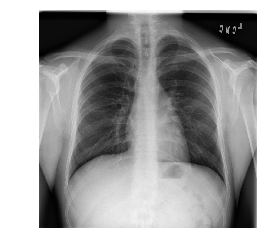

In [85]:
patient_test = df['patientId'][3]
print(patient_class.loc[patient_test])
draw(parsed[patient_test])

In [7]:
def path_to_tensor(img_path):
    """takes an image path and returns a 4D array/tensor 
    Keras CNNs expect 4D tensors in the format:
    (nb_samples, width, height, n_dim) """
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(df):
    list_of_tensors = [path_to_tensor(parsed[pid]['png']) for pid in tqdm(df['patientId'])]
    return np.vstack(list_of_tensors)

def target_to_tensor(df):
    list_of_tensors =[parsed[pid]['label'] for pid in df['patientId']]
    return np.vstack(list_of_tensors)

In [8]:
# Separate image data into training and validation sets
train_tensors = paths_to_tensor(df[:24848])
valid_tensors = paths_to_tensor(df[24848:])

100%|██████████| 4141/4141 [00:25<00:00, 162.48it/s]


In [9]:
# Separate labels into training and validation sets
train_targets = target_to_tensor(df[:24848])
valid_targets = target_to_tensor(df[24848:])

In [10]:
# Set up Resnet50 model and freeze the top layers - we don't want to retrain them
Resnet50_model = ResNet50(weights='imagenet',
                          include_top=False,
                          input_shape=train_tensors[0].shape)

for layer in Resnet50_model.layers:
    layer.trainable = False

/home/b/anaconda3/envs/py3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [11]:
# Image augmentation to improve accuracy and reduce overfitting
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

In [12]:
# Add some dense layers and a final output layer (true or false for pneumonia detection)
x = Resnet50_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)


# Tuning parameters
batch_size = 32
learning_rate = 1e-4
optimizer = Adam(lr=learning_rate)

r50_transfer = Model(inputs=Resnet50_model.input, outputs=predictions)
r50_transfer.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
# The model was not training with binary cross entropy despite only being 2 classes.
# Switched to categorical cross entropy and so need to convert labels to categorical.
from keras.utils import to_categorical
y_train = to_categorical(train_targets)
y_valid = to_categorical(valid_targets)

In [14]:
# Checkpoint to save the model when new best val_loss is achieved
checkpointer = ModelCheckpoint(filepath='weights_best_Resnet50-structure-v0.5.hdf5',
                              verbose=1, save_best_only=True)


In [15]:
r50_transfer.fit(train_tensors, y_train, epochs=10,
                batch_size=batch_size, callbacks=[checkpointer],
                validation_data=(valid_tensors, y_valid), shuffle=True)

Train on 24848 samples, validate on 4141 samples
Epoch 1/10
24848/24848 [==============================] - 85s 3ms/step - loss: 0.6183 - acc: 0.6742 - val_loss: 0.3764 - val_acc: 0.8010

Epoch 00001: val_loss improved from inf to 0.37643, saving model to weights_best_Resnet50-structure-v0.5.hdf5
Epoch 2/10
24848/24848 [==============================] - 78s 3ms/step - loss: 0.5357 - acc: 0.7026 - val_loss: 0.3767 - val_acc: 0.8068

Epoch 00002: val_loss did not improve from 0.37643
Epoch 3/10
24848/24848 [==============================] - 79s 3ms/step - loss: 0.5034 - acc: 0.7214 - val_loss: 0.4819 - val_acc: 0.8092

Epoch 00003: val_loss did not improve from 0.37643
Epoch 4/10
24848/24848 [==============================] - 82s 3ms/step - loss: 0.4745 - acc: 0.7321 - val_loss: 0.4296 - val_acc: 0.8090

Epoch 00004: val_loss did not improve from 0.37643
Epoch 5/10
24848/24848 [==============================] - 82s 3ms/step - loss: 0.4487 - acc: 0.7415 - val_loss: 0.5009 - val_acc: 0.8119

In [74]:
# Helpers for visualisation
from PIL import Image
import math
def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file,
                   width,
                   height,
                   mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## Visualisation and testing

The trained model achieved around 80% accuracy on the validation data. The next step is to visualise some of these results, displaying 25 images from the test data, and making a prediction using the trained model.

The final step is to test the model against data it has not been exposed to before. Taking 10 images from the web of chest X-Rays, the model will make a prediction for each one.

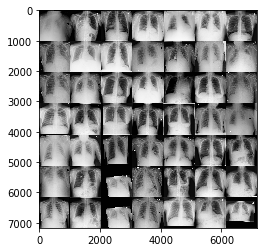

In [166]:
# Pull out some sample patients from our data
test_patient_ids = df[6700:6750]['patientId']

# Use our parser to get the file paths for the images of these 25 patients
test_patient_images = []
for pid in test_patient_ids:
    test_patient_images.append(parsed[pid]['png'])

# Use the get_batch helper to create an numpy array of the image data
t_im = get_batch(test_patient_images, 228, 228, 'L')

# Use the images_square_grid helper to display these images on a grid
plt.imshow(images_square_grid(t_im, 'L'))

In [167]:
from keras.models import load_model

# Load saved model
model = load_model('weights_best_Resnet50-structure-v0.5.hdf5')

# Set parameters
learning_rate = 1e-4
optimizer = Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/home/b/anaconda3/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


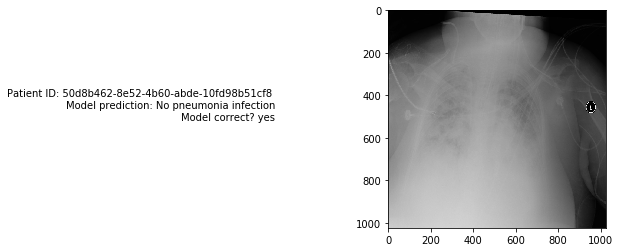

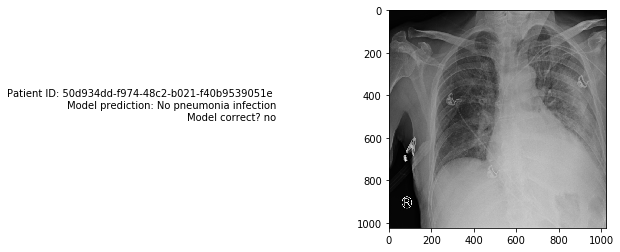

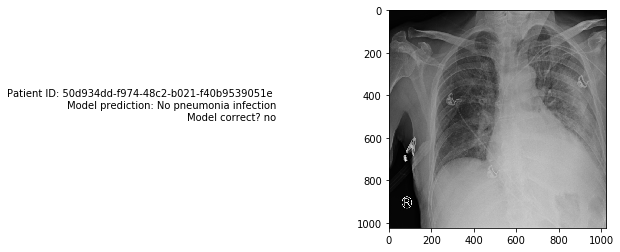

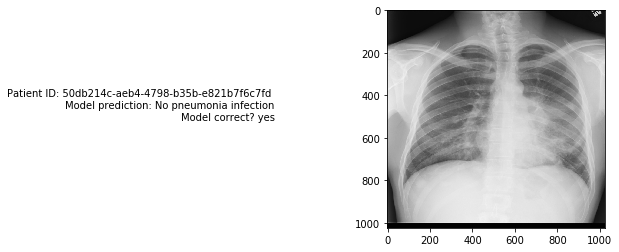

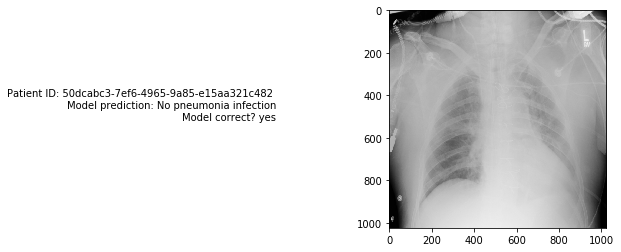

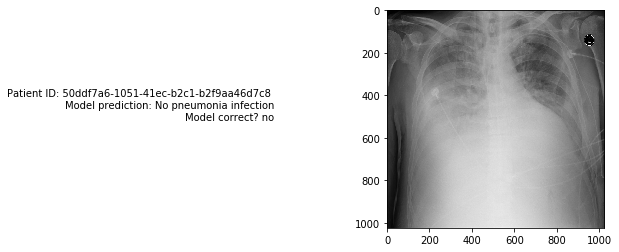

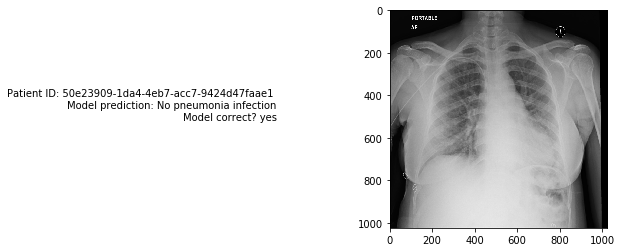

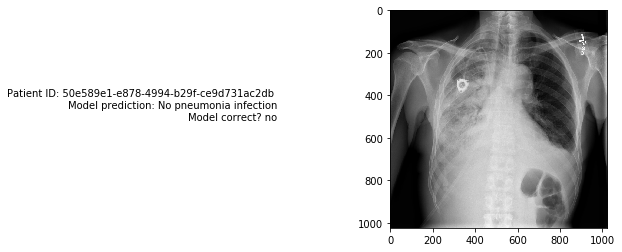

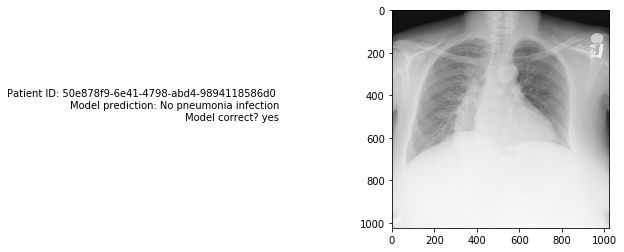

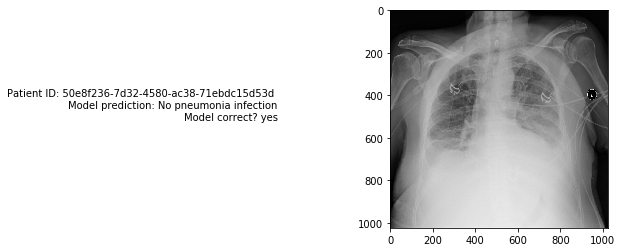

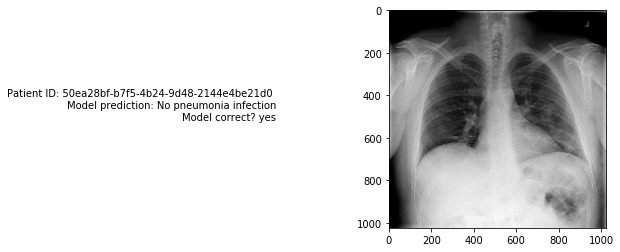

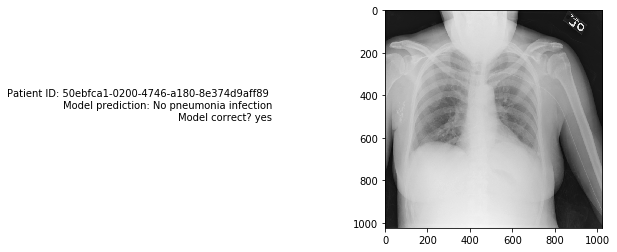

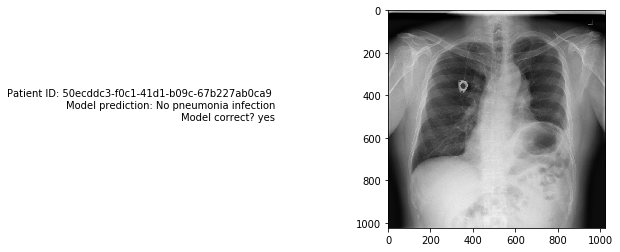

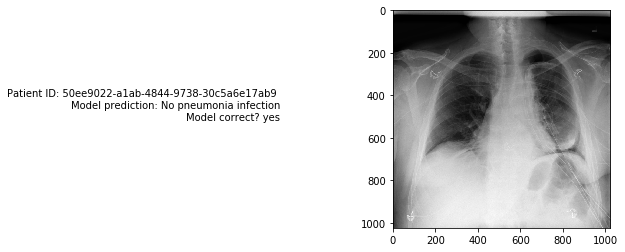

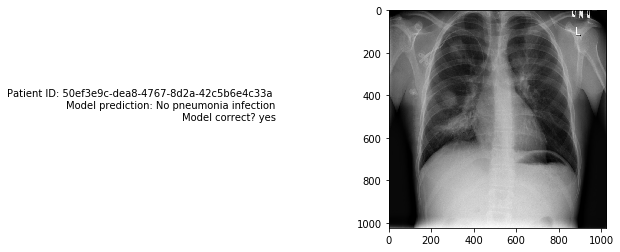

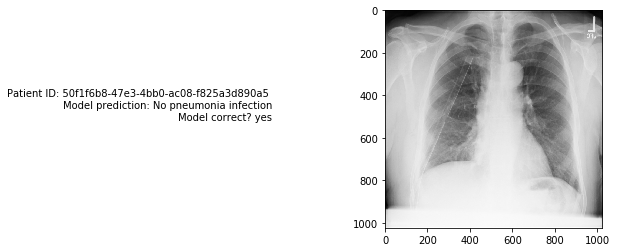

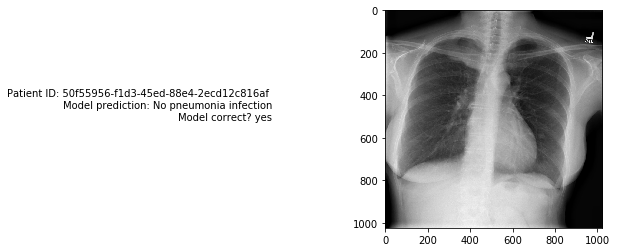

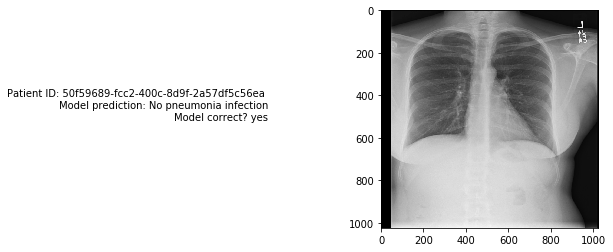

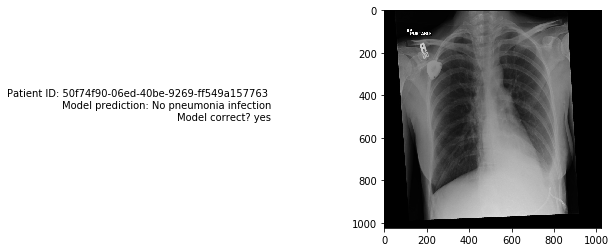

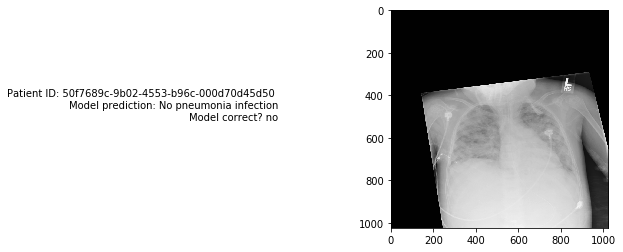

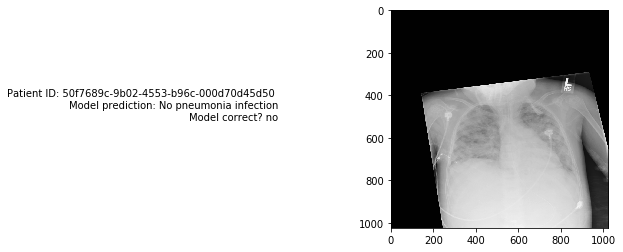

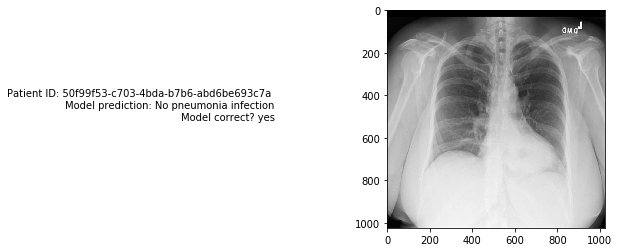

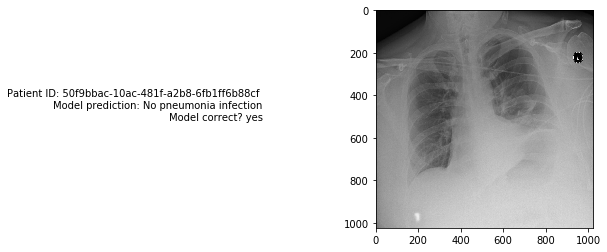

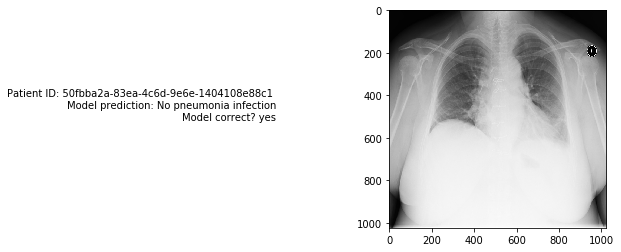

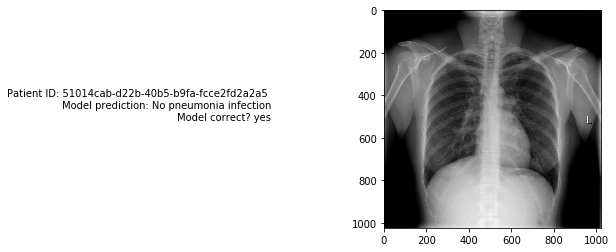

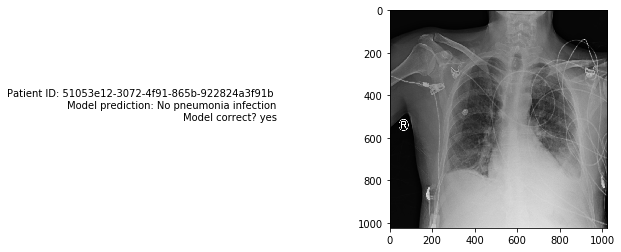

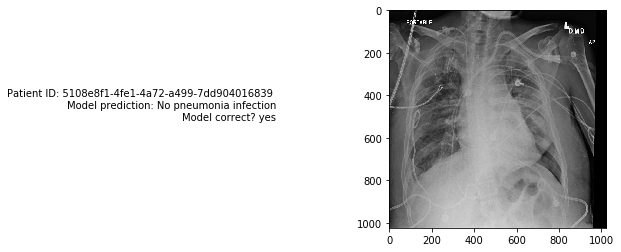

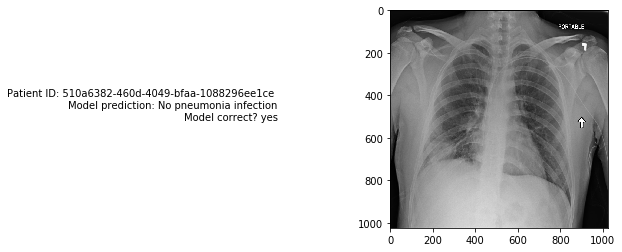

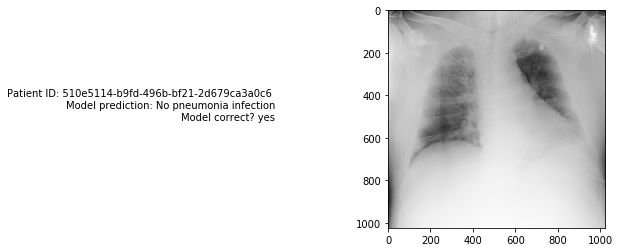

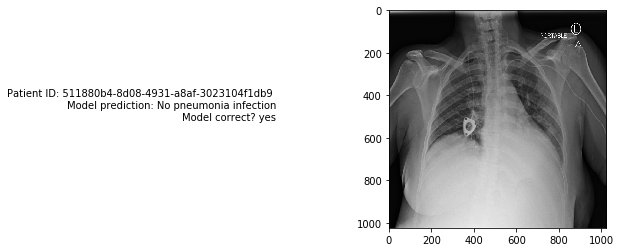

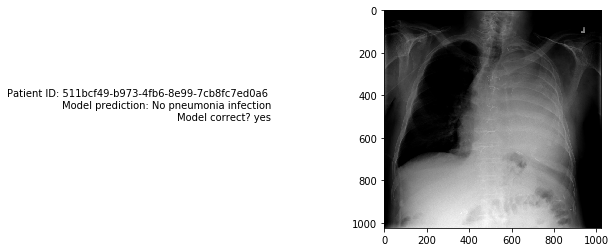

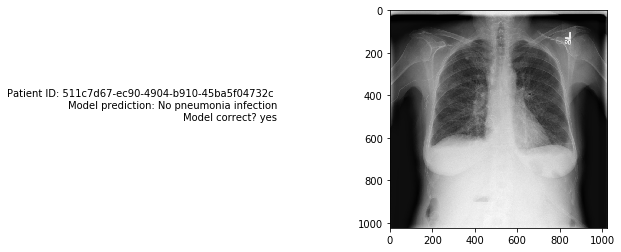

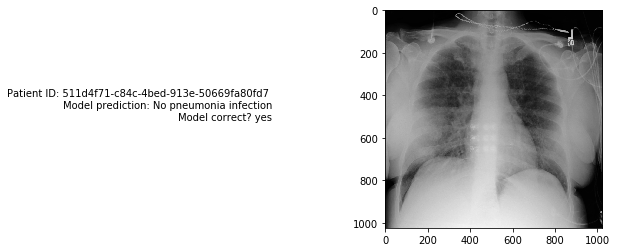

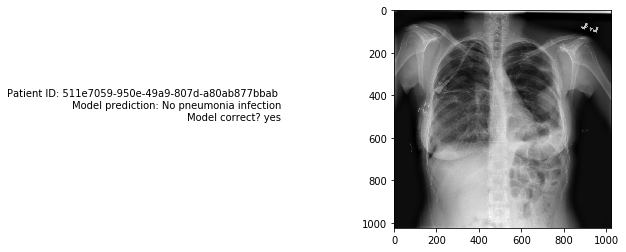

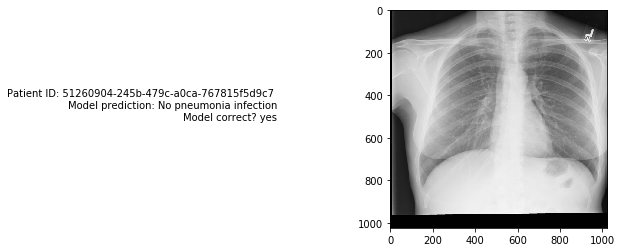

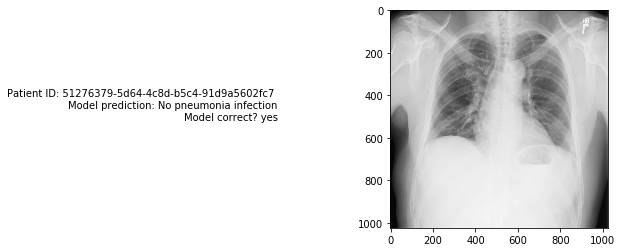

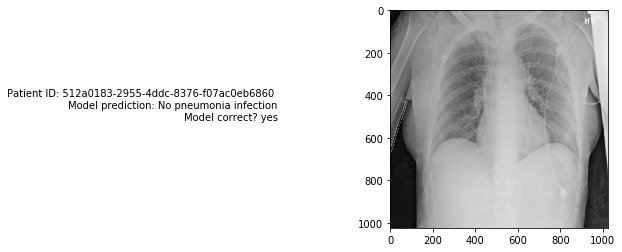

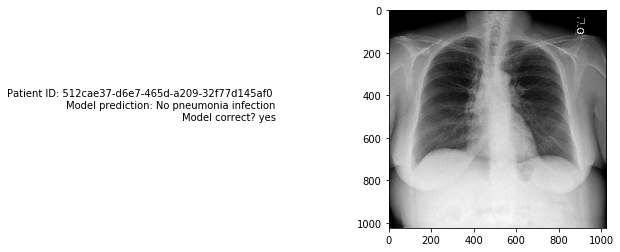

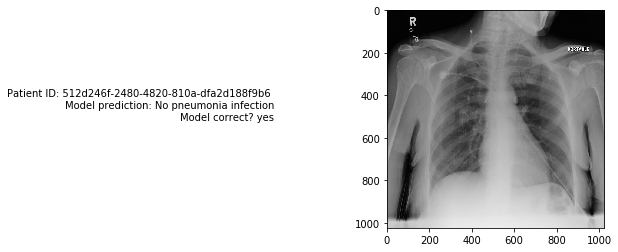

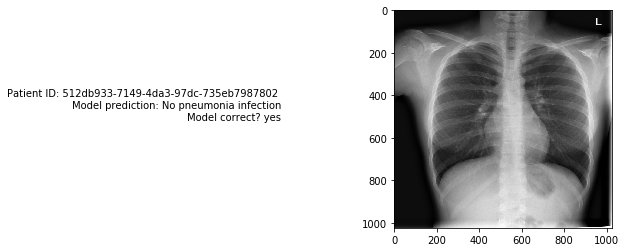

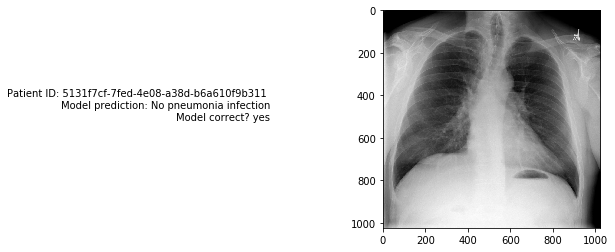

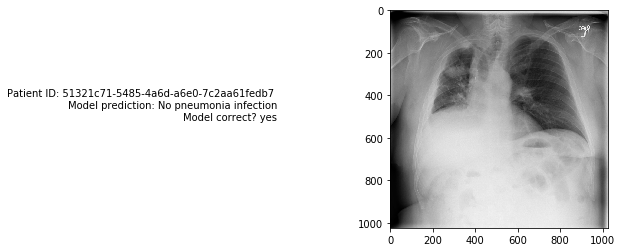

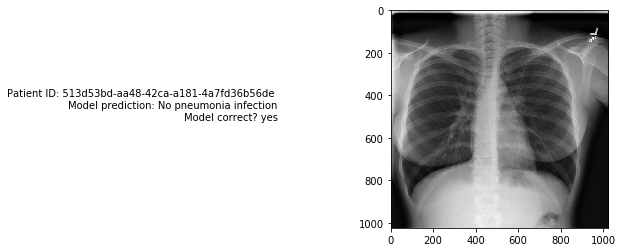

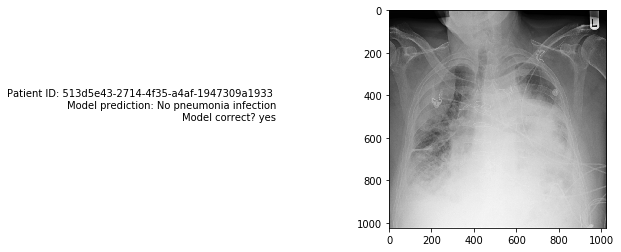

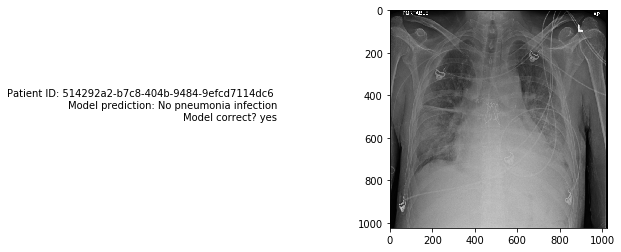

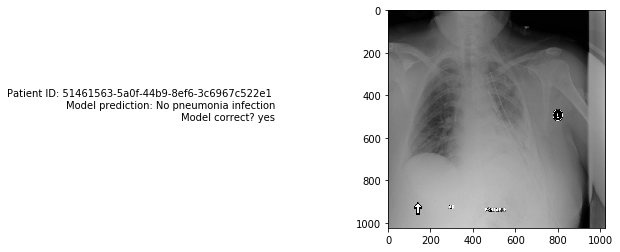

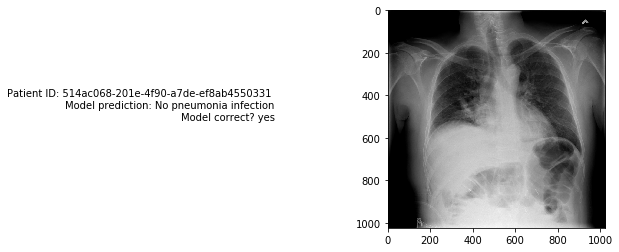

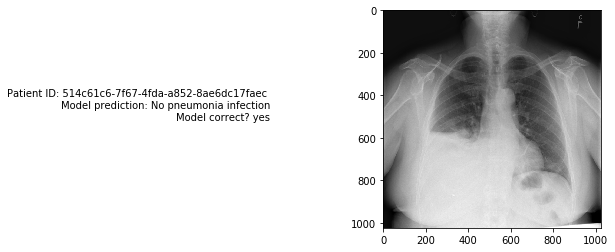

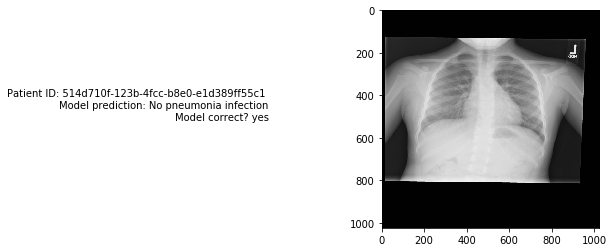

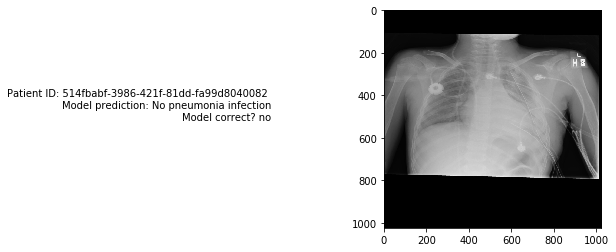

In [168]:
plt.close('all')
pred_correct = 0

for pid in test_patient_ids:
    fig = plt.figure()
    patient = parsed[pid]
    patient_img = cv2.imread(patient['png'])
    patient_tensor = path_to_tensor(patient['png'])
    patient_pred = np.argmax(model.predict(patient_tensor))
    patient_label = patient['label']
    
    if patient_pred == 1:
        pred = "Pneuomnia infection present"
    else:
        pred = "No pneumonia infection"
    
    if patient_pred == patient_label:
        model_correct = "yes"
        pred_correct += 1
    else:
        model_correct = "no"
    
    result_string = ("Patient ID: {0} \nModel prediction: {1}\nModel correct? {2}".format(pid, 
                                                                                          pred,
                                                                                          model_correct                                                                                         ))
    plt.imshow(patient_img)
    fig.text(-.0001, .5, result_string, ha='right')


In [169]:
print("Number of accurate predictions was {0} out of {1}".format(pred_correct, 
                                                                 len(test_patient_ids)))

Number of accurate predictions was 43 out of 50


In [187]:
test_infected_patients = []
count_infected = 0
pred_correct = 0

for pid in parsed:
        if parsed[pid]['label'] == 1:
            test_infected_patients.append(pid)
            count_infected += 1
            
for pid in test_infected_patients[:500]:
    patient = parsed[pid]
    patient_tensor = path_to_tensor(patient['png'])
    patient_pred = np.argmax(model.predict(patient_tensor))
    patient_label = patient['label']
    
    if patient_pred == 1:
        pred = "Pneuomnia infection present"
    else:
        pred = "No pneumonia infection"
    
    if patient_pred == patient_label:
        model_correct = "yes"
        pred_correct += 1
    else:
        model_correct = "no"
    
    result_string = ("Patient ID: {0} \nModel prediction: {1}\nModel correct? {2} \n\n".format(pid, 
                                                                                          pred,
                                                                                          model_correct))
    print(result_string)


Patient ID: 00436515-870c-4b36-a041-de91049b9ab4 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 00704310-78a8-4b38-8475-49f4573b2dbb 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 00aecb01-a116-45a2-956c-08d2fa55433f 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 00c0b293-48e7-4e16-ac76-9269ba535a62 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 00f08de1-517e-4652-a04f-d1dc9ee48593 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0100515c-5204-4f31-98e0-f35e4b00004a 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 010ccb9f-6d46-4380-af11-84f87397a1b8 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 012a5620-d082-4bb8-9b3b-e72d8938000c 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0174c4bb-28f5-41e3-a13f-a396badc18bd 
Model prediction: No pneumonia infection
Model correct

Patient ID: 06893030-14ab-456d-a22d-05070773e370 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 068b608d-f71c-4859-b909-62c1665b507f 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0695a0d8-d4b6-4dbe-bc04-497897e4516a 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0697baae-e475-4fa3-ad82-51b319a026cc 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 06a07f16-f6b5-4ae5-8f68-a97131fe4701 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 06a4f477-34ca-4625-945b-81bfa9e77273 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 06ac3c8c-cd1f-4e10-ac24-4cb4f3ab1243 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 06b52ffd-71b8-429a-a284-bb39240ed343 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 06b64e36-9e61-4865-bfe4-d96eef86548c 
Model prediction: No pneumonia infection
Model correct

Patient ID: 08e84251-b9cc-47e7-9486-be7becdd1d84 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 08ee8fda-45f1-4f46-a5ac-315a8d4dd196 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 08f17660-dc61-4a5d-b6fb-10dacc1e20a2 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 08f1b734-cd93-42c0-b978-9e1e1021bb55 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 08f580ca-6c0e-47ca-9759-851b3c0bb397 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 08f9a388-c195-4b33-8acd-e05d4da14585 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0902e0fc-fcf3-40b5-ac04-c3ecc14c2355 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0906c2ce-d3a7-43ad-af1b-1dadf70d8cc4 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0909a8b0-09e7-4a78-9bfb-417a61c6723c 
Model prediction: No pneumonia infection
Model correct

Patient ID: 0b1d5b23-c3ab-41b5-b82d-a16a3d6b5674 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0b202292-a925-4706-963f-28fd16cef0c2 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0b2057bc-4c6d-4c90-8975-94c02392e460 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0b323a31-28e6-45b2-a07c-cc9b60571053 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0b3b1768-5926-4084-bed0-ad9ae886d13a 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0b5fa34f-5c96-4cc5-becc-317acdff3221 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0b74faac-00a1-4958-9571-b5f7f9c52179 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0b7a4fb2-adab-484b-a0f7-23f5111bc745 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0b8e881f-67bc-4021-a02c-0087233e43aa 
Model prediction: No pneumonia infection
Model correct

Patient ID: 0f1fced1-4c33-44b2-9009-1370aa6287f3 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0f2bce55-7193-45d0-8223-d978b550477a 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0f3ac29b-7682-4402-bbe5-89e4add87639 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0f831256-0a69-4fe5-9719-1563d2b6b7b9 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0f8f22cd-112a-47c5-8069-d767ed01b112 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0f938aa7-9459-4c95-9b99-d0bf94cc789e 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 0fe227eb-592b-4ae5-b050-e7573d423953 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 1004476c-1b00-4ccd-9c72-193b6a048e15 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 104c55a0-70a6-49a7-a677-c170d356372a 
Model prediction: No pneumonia infection
Model correct

Patient ID: 164e8e2e-f90c-41d8-a7ee-cfee6fef16b2 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 165e4595-deeb-4910-b06b-89e2fba035f6 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 166088ea-38d0-4881-8a1a-7e6d5fc442dd 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 166479fb-b1f7-494c-b894-2ddf6d21131a 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 1677d8e0-7c1c-4052-923b-4fc0061c2ebd 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 1682a002-e834-4696-8101-70afe4edeebf 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 16860ea6-c3cc-4cc1-a405-9b2a242faf8e 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 16923fe0-5e98-4bcf-92e6-65d10161660d 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 16939adb-3468-4e45-9b87-0ec9a8b0f2ea 
Model prediction: No pneumonia infection
Model correct

Patient ID: 18bff0c2-16fa-4681-845a-c9a8f019ceaf 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 18c4af3d-0768-4f17-9c1f-d6f8199098ac 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 18cded58-0cce-4b19-93de-48082a7b7d4c 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 18ce990f-bea9-4174-a6a2-8f61c4517b24 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 18dea804-4283-4c5c-94ea-47c42bbb619e 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 18e76660-3742-44d3-94b5-62f1f7b027df 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 18e8b809-d2a0-4749-a4a4-23b1f4881839 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 18ee3d5a-1d35-4f91-bef4-da13e40c4935 
Model prediction: No pneumonia infection
Model correct? no 


Patient ID: 18f349ea-e436-443c-a040-c07c705f9989 
Model prediction: No pneumonia infection
Model correct

In [189]:
print("Number of accurate predictions was {0} out of 500".format(pred_correct))

Number of accurate predictions was 1 out of 500


## Model version 0.2 - Observations & Next steps
> x = Resnet50_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

>r50_transfer = Model(inputs=Resnet50_model.input, outputs=predictions)
r50_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

>batch_size = 32

**Observations**:
A _validation accuracy_ of 0.8190 was achieved by epoch 3 with a _loss_ of 2.89894. This did not increase again until epoch 8, which achieved a _validation accuracy_ of 0.8239 with a _loss_ of 2.83392.

**Next steps**:
Increase training sample size and reduce validation sample size, using more of the data for training. Previous training sample size was 22000. I have increased this to: 24848.

Old training sample size: 22000
Old validation sample size: 6989

New training sample size: 24848
New validation sample size 6989


## Model version 0.3 - Observations & Next steps
>x = Resnet50_model.output
>x = Flatten()(x)
>x = Dense(128, activation='relu')(x)
>x = Dropout(0.5)(x)
>x = Dense(128, activation='relu')(x)
>x = Dropout(0.5)(x)
>predictions = Dense(2, activation='softmax')(x)

>r50_transfer = Model(inputs=Resnet50_model.input, outputs=predictions)
>r50_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

>batch_size = 20

**Changes made**:
I have made the changes to the sample sizes as per findings in version 0.2. I have also decreased the batch size from 32 to 20, based on the paper "On Large-Batch Training for Deep Learning" which found that larger batches degraded the quality of the model.

**Observations**:
These changes resulted in the model converging very quickly, to an accuracy of 0.8013 with a validation loss of 3.20338. The model then oscillated and results did not improve for the remaining 9 epochs.

**Next steps**:
Return batch size to 32 to determine the cause of the effect (changes to training sample sizes or batch size). 


## Model version 0.4 - Observations & Next steps
>x = Resnet50_model.output
>x = Flatten()(x)
>x = Dense(128, activation='relu')(x)
>x = Dropout(0.5)(x)
>x = Dense(128, activation='relu')(x)
>x = Dropout(0.5)(x)
>predictions = Dense(2, activation='softmax')(x)

>r50_transfer = Model(inputs=Resnet50_model.input, outputs=predictions)
>r50_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

>batch_size = 32

**Changes made**:
Returned batch size to 32 after poor results from 0.3. It seemed unreasonable to assume that providing the model with more training data would have the effects noted in 0.3.

**Observations**:
Similar observations made to 0.2.

**Next steps**:
Reduce learning rate of adam optimizer from default of 0.001 to 1e-4. Perhaps this will help the model identified more nuanced features associated with lung opacities.

## Model version 0.5 - Observations & Next steps
>x = Resnet50_model.output
>x = Flatten()(x)
>x = Dense(128, activation='relu')(x)
>x = Dropout(0.5)(x)
>x = Dense(128, activation='relu')(x)
>x = Dropout(0.5)(x)
>predictions = Dense(2, activation='softmax')(x)

>r50_transfer = Model(inputs=Resnet50_model.input, outputs=predictions)
>r50_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

>batch_size = 32

**Changes made**:
Reduce learning rate of adam optimizer from default of 0.001 to 1e-4. 

**Observations**:
Significant reduction in loss from a best of 2.898 in v0.2 down to 0.50808. 
Accuracy also increased to 0.83 (previous high of 0.82 in v0.2). However, there is also evidence of overfitting around the 4th epoch onwards.

**Next steps**:
Reduce network size.

## Model version 0.5 - Observations & Next steps
>x = Resnet50_model.output
>x = Flatten()(x)
>x = Dense(128, activation='relu')(x)
>x = Dropout(0.5)(x)
>x = Dense(64, activation='relu')(x)
>x = Dropout(0.5)(x)
>predictions = Dense(2, activation='softmax')(x)

>r50_transfer = Model(inputs=Resnet50_model.input, outputs=predictions)
>r50_transfer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

>batch_size = 32

**Changes made**:
Final dense layer reduced by 50%.

**Observations**:
Overfitting has reduced. 

**Next steps**:
This PoC exercise using Keras is complete. Will consider developing a more complex model using Tensorflow that segments lungs and also considers DICOM data.